# Laba 3

In [56]:
import numpy as np
import pandas as pd
import graphblas as gb
import random
from graphblas.io import mmread
from graphblas import Matrix, Vector
from graphblas import dtypes
from graphblas import binary, semiring
import os
import time
import plotly.express as px

# #1 Bellman–Ford (1 стартовая вершина)

In [33]:
def Bellman_Ford(A, vertex):
    m = A.nrows
    v = Vector(A.dtype, m)
    v[vertex] << 0
    
    w = v.dup()
    for i in range(m - 1):
        w_old = w.dup()
        w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
            
    w_old = w.dup()
    w(binary.min) << w.vxm(A, semiring.min_plus)
    
    if not w.isequal(w_old):
        raise RuntimeError("Присутствует цикл отрицательного веса")
        
    result = []
    for i in range(m):
        if w[i].value is None:
            result.append(float('inf'))
        else:
            result.append(w[i].value)
    return result

# #2 Bellman–Ford (несколько стартовых вершин)

In [51]:
def Bellman_Ford_mult(A, vertices):
    n = A.ncols
    m = vertices.size
    
    v = Matrix(dtypes.INT32, m, n)
    for i in range(m):
        v[i, vertices[i]] << 0

    w = v.dup()
    for i in range(n - 1):
        w_old = w.dup()
        for i in range(m):
            w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
    
    w_old = w.dup()
    for i in range(m):
        w[i,:](binary.min) << w[i,:].vxm(A, semiring.min_plus)
    if not w.isequal(w_old):
        raise RuntimeError('Присутствует цикл отрицательного веса')
        
    result = {}
    for i in range(m):
        values = []
        for j in range(n):
            if w[i, j].value is None: 
                values.append(float('inf'))
            else:
                values.append(w[i, j].value)
        result[vertices[i]] = (values)
    return result

# #3 Floyd–Warshall

In [35]:
def Floyd_Warshall(matrix):
    dist = matrix.dup()
    n = matrix.nrows
    temp_dist = matrix.dup()
    
    for k in range(n):
        
        dist_col = Matrix(dtypes.INT32, n, n)
        dist_row = Matrix(dtypes.INT32, n, n)
        dist_col[:, k] = dist[:, k].dup()
        dist_row[k, :] = dist[k, :].dup()
        temp_dist << dist_col.mxm(dist_row, semiring.min_plus)

        dist << dist.ewise_add(temp_dist, op="min")
        
    dist_cop = dist.dup()
    temp_dist_cop = temp_dist.dup()
    dist_col_cop = Matrix(dtypes.INT32, n, n)
    dist_row_cop = Matrix(dtypes.INT32, n, n)
    dist_col_cop[:, k] = dist_cop[:, k].dup()
    dist_row_cop[k, :] = dist_cop[k, :].dup()
    temp_dist_cop << dist_col_cop.mxm(dist_row_cop, semiring.min_plus)
    dist_cop << dist_cop.ewise_add(temp_dist_cop, op="min")
    
    if not dist_cop.isequal(dist):
        raise RuntimeError('Присутствует цикл отрицательного веса')

    result = {}
    for i in range(n):
        val_list = []
        for j in range(n):
            if i == j:
                val_list.append(0)
            elif dist[i, j].value is None:
                val_list.append(float('inf'))
            else:
                val_list.append(dist[i, j].value)
        result[i] = np.array(val_list)
    return result


# #3 Вычисление транзитивного замыкания

In [36]:
def Transitive_Closure(m):
    rows = m.nrows
    I = Matrix(dtypes.INT32, rows, rows)
    
    for i in range(rows):
        I[i, i] = 1
    D = I.dup()
    for i in range(rows):
        D1 = D.dup()
        D = D.mxm(m, semiring.min_plus).ewise_add(I, op="min")
        if D1.isequal(D):
            break
    
    D2 = D.dup()
    D2 = D2.mxm(m, semiring.min_plus).ewise_add(I, op="min")
    if not D2.isequal(D):
        raise RuntimeError('Присутствует цикл отрицательного веса')

    result = {}
    for i in range(rows):
        ar_val = []
        for j in range(rows):
            if D[i, j].value is None:
                ar_val.append(float('inf'))
            elif i == j:
                ar_val.append(0)
            else:
                ar_val.append(D[i, j].value - 1)
        result[i] = np.array(ar_val)
    return result

# #4  Тесты

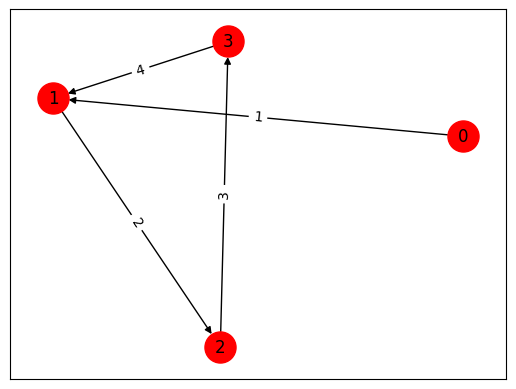

In [37]:
import numpy as np

data = [
    [0, 1, 2, 3],
    [1, 2, 3, 1],
    [1, 2, 3, 4],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(m)

In [38]:
print('Bellman-Ford:', Bellman_Ford(m, 0))
# [0, 1, 3, 6]
print('Bellman-Ford:', Bellman_Ford(m, 1))
# [inf, 0, 2, 5]
print('Bellman-Ford:', Bellman_Ford(m, 2))
# [inf, 7, 0, 3]

Bellman-Ford: [0, 1, 3, 6]
Bellman-Ford: [inf, 0, 2, 5]
Bellman-Ford: [inf, 7, 0, 3]


In [39]:
starting_vertices = np.array([1,2])
print('Bellman-Ford mult:', Bellman_Ford_mult(m, starting_vertices))
# 1: [inf, 0, 2, 5]
# 2: [inf, 7, 0, 3]

Bellman-Ford mult: {1: [inf, 0, 2, 5], 2: [inf, 7, 0, 3]}


In [40]:
print('Floyd-Warshall:', Floyd_Warshall(m))
# (0: [0, 1, 3, 6]
# (1: [inf,  0.,  2.,  5.]
# (2: [inf,  7.,  0.,  3.]
# (3:[inf,  4.,  6.,  0.]


Floyd-Warshall: {0: array([0, 1, 3, 6]), 1: array([inf,  0.,  2.,  5.]), 2: array([inf,  7.,  0.,  3.]), 3: array([inf,  4.,  6.,  0.])}


In [41]:
print('Transitive Closure:', Transitive_Closure(m))
# (0: [0, 1, 3, 6]
# (1: [inf,  0.,  2.,  5.]
# (2: [inf,  7.,  0.,  3.]
# (3:[inf,  4.,  6.,  0.]

Transitive Closure: {0: array([0, 1, 3, 6]), 1: array([inf,  0.,  2.,  5.]), 2: array([inf,  7.,  0.,  3.]), 3: array([inf,  4.,  6.,  0.])}


результаты, посчитанные разными способами, сходятся => всё верно

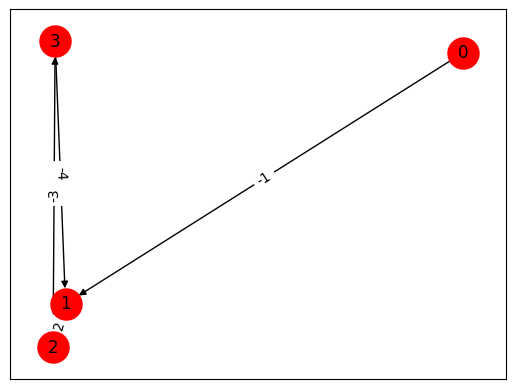

In [42]:
data = [
    [0, 1, 2, 3],
    [1, 2, 3, 1],
    [-1, 2, -3, -4],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(m)

In [43]:
Bellman_Ford(m, 2)

RuntimeError: Присутствует цикл отрицательного веса

в каждой функции происходит отлов всех графов, в которых присутствует х/б один цикл отрицательного веса 

# #5 Экспериментальное исследование

In [60]:
graph_names = ['bcsstk01.mtx', 'bcsstk05.mtx', 'can_445.mtx'] # названия графов

In [54]:
def test_Bellman_Ford(A, vertex):
    start = time.time()
    Bellman_Ford(A, vertex)
    end = time.time()
    working_time = (end-start)
    return working_time

def test_Bellman_Ford_mult(A, vertices):
    start = time.time()
    Bellman_Ford_mult(A, vertices)
    end = time.time()
    working_time = (end-start)
    return working_time

def test_Floyd_Warshall(A):
    start = time.time()
    Floyd_Warshall(A)
    end = time.time()
    working_time = (end-start)
    return working_time

def test_Transitive_Closure(A):
    start = time.time()
    Transitive_Closure(A)
    end = time.time()
    working_time = (end-start)
    return working_time

In [52]:
def vertex_generate(n, p):
    population = range(n)
    vertex_array = random.sample(population, round(n * p))
    return np.array(vertex_array)

In [53]:
def generation_start_vertices(num_vertices, frequency):
    start_vertices = random.sample(range(num_vertices), int(num_vertices * frequency/100))
    return np.array(start_vertices)

In [62]:
graph_names

['bcsstk01.mtx', 'bcsstk05.mtx', 'can_445.mtx']

In [87]:
vertex_frequency=[5, 20, 80]

graphs_metrics_levels = pd.DataFrame(columns=['Метод', 'Файл', 'Количество вершин', 'Степень разреженности', 'Количество стартовых вершин', 'Время'])
graph_names = os.listdir('graphs3')
for graph_name in graph_names:
    graph = mmread(f'graphs3/{graph_name}')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    for vertex_freq in vertex_frequency:
        working_time = test_Bellman_Ford(graph, generation_start_vertices(graph.nrows, vertex_freq))
        graphs_metrics_levels.loc[len(graphs_metrics_levels)] = 'Bellman-Ford', graph_name, num_vertices, rerefaction_deg, int(vertex_freq/100 * graph.nrows), working_time
        working_time = test_Bellman_Ford_mult(graph, generation_start_vertices(graph.nrows, vertex_freq))
        graphs_metrics_levels.loc[len(graphs_metrics_levels)] = 'Bellman-Ford mult', graph_name, num_vertices, rerefaction_deg, int(vertex_freq/100 * graph.nrows), working_time

In [88]:
graphs_metrics_levels

,Метод,Файл,Количество вершин,Степень разреженности,Количество стартовых вершин,Время
0,Bellman-Ford,can_1072.mtx,1072,0.010839,53,0.045649
1,Bellman-Ford mult,can_1072.mtx,1072,0.010839,53,2.896208
2,Bellman-Ford,can_1072.mtx,1072,0.010839,214,0.052159
3,Bellman-Ford mult,can_1072.mtx,1072,0.010839,214,13.290549
4,Bellman-Ford,can_1072.mtx,1072,0.010839,857,0.038340
5,Bellman-Ford mult,can_1072.mtx,1072,0.010839,857,46.168129
6,Bellman-Ford,can_229.mtx,229,0.034034,11,0.012479
7,Bellman-Ford mult,can_229.mtx,229,0.034034,11,0.132843
8,Bellman-Ford,can_229.mtx,229,0.034034,45,0.017202
9,Bellman-Ford mult,can_229.mtx,229,0.034034,45,0.553029


## Генерация случайных графов

In [69]:
def generate_graph(n_rows, density):
    
    A = gb.Matrix(int, n_rows, n_rows)
    while density > 0:
        i = random.randint(0, n_rows - 1)
        j = random.randint(0, n_rows - 1)
        if A.get(i,j) is None and i != j:
            weight = random.randint(0, 10)
            A[i,j] = weight
            A[j,i] = weight
            density = density - 1
    return A

зависимость от числа вершин

In [70]:
graphs_gen_metrics = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин', 'Функция', 'Время'])
for i in [100, 200, 400, 600, 800]:
    fix_raref_deg, share_starts = 0.5, 40 
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))

    BF = test_Bellman_Ford(generated_graph, generation_start_vertices(i, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = i, fix_raref_deg, share_starts, 'Bellman_Ford', BF

    BFM = test_Bellman_Ford_mult(generated_graph, generation_start_vertices(i, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = i, fix_raref_deg, share_starts, 'Bellman_Ford_mult', BFM

    FM = test_Floyd_Warshall(generated_graph)
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = i, fix_raref_deg, share_starts, 'Floyd_Warshall', FM
    
    TC = test_Transitive_Closure(generated_graph)
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = i, fix_raref_deg, share_starts, 'Transitive_Closure', TC

In [72]:
graphs_gen_metrics['Время/Кол-во вершин'] = graphs_gen_metrics['Время']/graphs_gen_metrics['Количество вершин']
graphs_gen_metrics.sort_values('Функция')

,Количество вершин,Степень разреженности,Доля стартовых вершин,Функция,Время,Время/Кол-во вершин
0,100,0.5,40,Bellman_Ford,0.008105,0.000081
16,800,0.5,40,Bellman_Ford,0.029081,0.000036
4,200,0.5,40,Bellman_Ford,0.010410,0.000052
12,600,0.5,40,Bellman_Ford,0.033328,0.000056
8,400,0.5,40,Bellman_Ford,0.015010,0.000038
17,800,0.5,40,Bellman_Ford_mult,14.625512,0.018282
13,600,0.5,40,Bellman_Ford_mult,8.156523,0.013594
9,400,0.5,40,Bellman_Ford_mult,3.996495,0.009991
5,200,0.5,40,Bellman_Ford_mult,0.923298,0.004616
1,100,0.5,40,Bellman_Ford_mult,0.250086,0.002501


зависимость от разреженности графа

In [ ]:
graphs_gen_metrics1 = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин, %', 'Функция', 'Время'])
for i in [0.2, 0.5]:
    num_vert, share_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    
    BF = test_Bellman_Ford(generated_graph, generation_start_vertices(num_vert, share_starts))
    graphs_gen_metrics1.loc[len(graphs_gen_metrics1)] = num_vert, i, share_starts, 'Bellman_Ford', BF

    BFM = test_Bellman_Ford_mult(generated_graph, generation_start_vertices(num_vert, share_starts))
    graphs_gen_metrics1.loc[len(graphs_gen_metrics1)] = num_vert, i, share_starts, 'Bellman_Ford_mult', BFM

    FM = test_Floyd_Warshall(generated_graph)
    graphs_gen_metrics1.loc[len(graphs_gen_metrics1)] = num_vert, i, share_starts, 'Floyd_Warshall', FM
    
    TC = test_Transitive_Closure(generated_graph)
    graphs_gen_metrics1.loc[len(graphs_gen_metrics1)] = num_vert, i, share_starts, 'Transitive_Closure', TC

In [84]:
graphs_gen_metrics1.sort_values('Функция')

,Степень разреженности,Количество вершин,"Доля стартовых вершин, %",Функция,Время
0,0.2,500,50,Bellman_Ford,0.019607
4,0.5,500,50,Bellman_Ford,0.020782
1,0.2,500,50,Bellman_Ford_mult,7.156956
5,0.5,500,50,Bellman_Ford_mult,7.762369
2,0.2,500,50,Floyd_Warshall,15.938568
6,0.5,500,50,Floyd_Warshall,14.600273
3,0.2,500,50,Transitive_Closure,14.195359
7,0.5,500,50,Transitive_Closure,14.393728


Зависимость от числа стартовых вершин

In [85]:
graphs_gen_metrics2 = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин', 'Функция', 'Время'])
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))

    BF = test_Bellman_Ford(generated_graph, generation_start_vertices(num_vert, i))
    graphs_gen_metrics2.loc[len(graphs_gen_metrics2)] = num_vert, fix_raref_deg, i, 'Bellman_Ford', BF

    BFM = test_Bellman_Ford_mult(generated_graph, generation_start_vertices(num_vert, i))
    graphs_gen_metrics2.loc[len(graphs_gen_metrics2)] = num_vert, fix_raref_deg, i, 'Bellman_Ford_mult', BFM

    FM = test_Floyd_Warshall(generated_graph)
    graphs_gen_metrics2.loc[len(graphs_gen_metrics2)] = num_vert, fix_raref_deg, i, 'Floyd_Warshall', FM
    
    TC = test_Transitive_Closure(generated_graph)
    graphs_gen_metrics2.loc[len(graphs_gen_metrics2)] = num_vert, fix_raref_deg, i, 'Transitive_Closure', TC

In [86]:
graphs_gen_metrics2.sort_values('Функция')

,Количество вершин,Степень разреженности,Доля стартовых вершин,Функция,Время
0,500,0.5,20,Bellman_Ford,0.029635
4,500,0.5,40,Bellman_Ford,0.037478
8,500,0.5,60,Bellman_Ford,0.018217
12,500,0.5,80,Bellman_Ford,0.018428
1,500,0.5,20,Bellman_Ford_mult,3.004797
5,500,0.5,40,Bellman_Ford_mult,5.865424
9,500,0.5,60,Bellman_Ford_mult,10.249669
13,500,0.5,80,Bellman_Ford_mult,11.658597
2,500,0.5,20,Floyd_Warshall,13.286887
6,500,0.5,40,Floyd_Warshall,14.354876


# Выводы:
Тестирование на реальных графах показало, что на небольших графах классический алгоритм Bellman-Fold работает эффективнее модифицированного, однако на больших данных модифицированный алгоритм показывает более высокие результаты.

В то же время, тестирование на случайно сгенерированных графах показало, что на малых графах (до 100 вершин) классический алгоритм работает эффективнее, независимо от количества стартовых вершин. Разреженность графа не оказывает существенного влияния на работу алгоритмов. Более того, даже если взять 100% вершин в качестве стартовых, модифицированный алгоритм все еще немного уступает классическому по времени выполнения.

Начиная с доли вершин в графе равной 40-50%, целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин (Floyd–Warshall или транзитивное замыкание), чем решать задачу поиска кратчайших путей из нескольких стартовых вершин (модифицированный Bellman-Ford). Это объясняется тем, что алгоритмы для всех пар вершин имеют более высокую асимптотическую сложность, но при большом количестве стартовых вершин они выполняются быстрее, чем модифицированный алгоритм Беллмана-Форда. В то же время, для меньших долей вершин, модифицированный алгоритм Беллмана-Форда показывает лучшие результаты, особенно при использовании нескольких стартовых вершин.

# #6 Использование push/pull direction optimization

In [89]:
def Bellman_Ford_push_pull(A, vertex, push_pull_percent=0.0):
    n = A.nrows
    v = Vector(dtypes.INT64, n)
    v[vertex] << 0
    w = v.dup()
    
    for _ in range(n - 1):
        last_w = w.dup()
        if push_pull_percent == 0.0:
            w(binary.min) << w.vxm(A, semiring.min_plus)
        elif push_pull_percent == 1.0:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        else:
            if w.nvals / w.size > push_pull_percent:
                w(binary.min) << A.T.mxv(w, semiring.min_plus)
            else:
                w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(last_w):
            break
      
    last_w = w.dup()
    if push_pull_percent == 0.0:
        w(binary.min) << w.vxm(A, semiring.min_plus)
    elif push_pull_percent == 1.0:
        w(binary.min) << A.T.mxv(w, semiring.min_plus)
    else:
        if w.nvals / w.size > push_pull_percent:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        else:
            w(binary.min) << w.vxm(A, semiring.min_plus)
            
    if not w.isequal(last_w):
        return 'Присутсвует цикл отрицательного веса'

    result = Vector(dtypes.FP64, n)
    for i in range(n):
        if w[i].value is None:
            result[i] << float('inf')
        else:
            result[i] << w[i]
    return result

In [90]:
def Bellman_Ford_mult_push_pull(A, start_vertices, push_pull_percent=0.0):
    n = A.ncols
    number_of_start_vertex = len(start_vertices)
    f = Matrix(dtypes.INT64, number_of_start_vertex, n)
    for ind, val in enumerate(start_vertices):
        f[ind, val] << 0
    w = f.dup()
    for _ in range(n - 1):
        last_w = w.dup()
        for i in range(number_of_start_vertex):
            if push_pull_percent == 0.0:
                w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
            elif push_pull_percent == 1.0:
                w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
            else:
                if w[i, :].nvals / w[i, :].size > push_pull_percent:
                    w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
                else:
                    w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)              
        if w.isequal(last_w):
            break

    last_w = w.dup()
    for i in range(number_of_start_vertex):
        if push_pull_percent == 0.0:
            w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
        elif push_pull_percent == 1.0:
            w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
        else:
            if w[i, :].nvals / w[i, :].size > push_pull_percent:
                w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
            else:
                w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)              
    if not w.isequal(last_w):
        return 'Присутсвует цикл отрицательного веса'

    result = Matrix(dtypes.FP64, number_of_start_vertex, n)
    for i in range(number_of_start_vertex):
        for j in range(n):
            if w[i,j].value is None:
                result[i,j] << float('inf')
            else:
                result[i,j] << w[i,j]
    return result

In [91]:
def test_Bellman_Ford_push_pull(A, vertex, i):
    start = time.time()
    Bellman_Ford_push_pull(A, vertex, i)
    end = time.time()
    working_time = (end-start)
    return working_time

def test_Bellman_Ford_mult_push_pull(A, vertices, i):
    start = time.time()
    Bellman_Ford_mult_push_pull(A, vertices, i)
    end = time.time()
    working_time = (end-start)
    return working_time

## Bellman-Ford push/pull

In [126]:
resume = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Количество стартовых вершин', 'Уровень push/pull', 'Время'])
count_vertices = [400, 600, 1000, 2000, 3000, 5000]
densityes = [0.1, 0.3, 0.6, 0.7, 0.8, 0.9, 1]

for count_vertice in count_vertices:
    for density in densityes:
        graph = generate_graph(count_vertice, density)
        for i in [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]:
            work_time = test_Bellman_Ford_push_pull(graph, range(0,int(count_vertice*0.1)), i)
            resume.loc[len(resume)] = count_vertice, density, int(count_vertice*0.1), i, work_time


In [127]:
resume

,Количество вершин,Степень разреженности,Количество стартовых вершин,Уровень push/pull,Время
0,400.0,0.1,40.0,0.0,0.013108
1,400.0,0.1,40.0,0.1,0.019651
2,400.0,0.1,40.0,0.3,0.005203
3,400.0,0.1,40.0,0.5,0.020045
4,400.0,0.1,40.0,0.7,0.011795
...,...,...,...,...,...
247,5000.0,1.0,500.0,0.1,0.175691
248,5000.0,1.0,500.0,0.3,0.189024
249,5000.0,1.0,500.0,0.5,0.156520
250,5000.0,1.0,500.0,0.7,0.149661


In [128]:
px.scatter(resume, x = 'Количество вершин', y = 'Время', color = 'Уровень push/pull')

In [129]:
px.scatter(resume, x = 'Степень разреженности', y = 'Время', color = 'Уровень push/pull')

In [130]:
px.scatter(resume, x = 'Количество стартовых вершин', y = 'Время', color = 'Уровень push/pull')

In [131]:
px.scatter(resume, x = 'Уровень push/pull', y = 'Время', color = 'Количество вершин')

In [139]:
compet = pd.DataFrame(columns=['Функция', 'Количество вершин', 'Степень разреженности', 'Количество стартовых вершин', 'Уровень push/pull', 'Время'])
count_vertices = [400, 600, 1000, 3000, 5000]
densityes = [0.1, 0.3, 0.6, 0.7, 0.8, 0.9, 1]

for count_vertice in count_vertices:
    for density in densityes:
        graph = generate_graph(count_vertice, density)
        for i in [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]:
            work_time = test_Bellman_Ford(graph, range(0,int(count_vertice*0.1)))
            compet.loc[len(compet)] = 'classic', count_vertice, density, int(count_vertice*0.1), np.nan, work_time
            work_time = test_Bellman_Ford_push_pull(graph, range(0,int(count_vertice*0.1)), i)
            compet.loc[len(compet)] = 'push_pull', count_vertice, density, int(count_vertice*0.1), i, work_time
compet


,Функция,Количество вершин,Степень разреженности,Количество стартовых вершин,Уровень push/pull,Время
0,classic,400,0.1,40,NaN,0.004465
1,push_pull,400,0.1,40,0.0,0.018927
2,classic,400,0.1,40,NaN,0.010441
3,push_pull,400,0.1,40,0.1,0.011998
4,classic,400,0.1,40,NaN,0.005455
...,...,...,...,...,...,...
415,push_pull,5000,1.0,500,0.5,0.142575
416,classic,5000,1.0,500,NaN,0.080150
417,push_pull,5000,1.0,500,0.7,0.140224
418,classic,5000,1.0,500,NaN,0.089180


In [141]:
px.scatter(compet, x = 'Функция', y = 'Время', color = 'Уровень push/pull')

In [142]:
px.scatter(compet, x = 'Функция', y = 'Время', color = 'Количество вершин')

## Bellman-Ford mult push/pull

In [155]:
range(0,int(500*0.1))

range(0, 50)

In [ ]:
resume1 = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Количество стартовых вершин', 'Уровень push/pull', 'Время'])
count_vertices = [400, 600, 1000, 3000]
densityes = [0.1, 0.3, 0.6, 0.8, 1]

for count_vertice in count_vertices:
    for density in densityes:
        graph = generate_graph(count_vertice, density)
        for i in [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]:
            work_time = test_Bellman_Ford_mult_push_pull(graph, range(0, int(count_vertice*0.1)), i)
            resume1.loc[len(resume1)] = count_vertice, density, int(count_vertice*0.1), i, work_time


In [161]:
resume1

,Количество вершин,Степень разреженности,Количество стартовых вершин,Уровень push/pull,Время
0,400.0,0.1,40.0,0.0,0.645916
1,400.0,0.1,40.0,0.1,0.621133
2,400.0,0.1,40.0,0.3,0.761393
3,400.0,0.1,40.0,0.5,0.632513
4,400.0,0.1,40.0,0.7,0.632320
...,...,...,...,...,...
98,3000.0,0.3,300.0,0.3,32.948505
99,3000.0,0.3,300.0,0.5,34.388400
100,3000.0,0.3,300.0,0.7,33.185493
101,3000.0,0.3,300.0,1.0,33.009961


In [162]:
px.scatter(resume1, x = 'Количество вершин', y = 'Время', color = 'Уровень push/pull')

In [163]:
px.scatter(resume1, x = 'Степень разреженности', y = 'Время', color = 'Уровень push/pull')

In [164]:
px.scatter(resume1, x = 'Количество стартовых вершин', y = 'Время', color = 'Уровень push/pull')

# Выводы:
Заметна линейная зависимость времени при использовании push_pull от размера графа и количества стартовых вершин. При этом степень разреженности особо не оказывает никакого влияния на время работы алгоритма.
Уровень pull/push не влияет на время работы алгоритма.

В сравнении с классическим алгоритмом, push/pull работает медленнее для всех групп графов (по размеру)

В целом, применение pull/push на рассмотренные графы не оказывает влияние.

